# Pixel classification using Scikit image in napari
Pixel classification is a technique for assigning pixels to multiple classes. If there are two classes (object and background), we are talking about binarization. In this example we use a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) for pixel classification. Together with an interactive user interface such as [napari](https://github.com/napari/napari) segmenting images like this is real fun!

See also
* [Scikit-image random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Classification of land cover by Chris Holden](https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)

As usual, we start by loading an example image.

In [5]:
import napari

from skimage.io import imread, imshow
from skimage import filters
import numpy as np

from sklearn.ensemble import RandomForestClassifier

In [6]:
image = imread('blobs.tif')

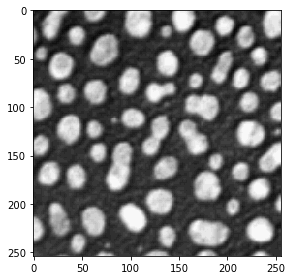

In [7]:
imshow(image)

## Generating a feature stack
Pixel classifiers such as the random forest classifier takes multiple images as input. We typically call these images a feature stack because for every pixel exist now multiple values (features). In the following example we create a feature stack containing three features:
* The original pixel value
* The pixel value after a Gaussian blur
* The pixel value of the Gaussian blurred image processed through a Sobel operator.

Thus, we denoise the image and detect edges. All three images serve the pixel classifier to differentiate positive an negative pixels.

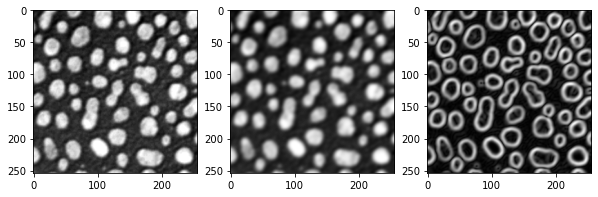

In [8]:
def generate_feature_stack(image):
    # determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here. 
    feature_stack = [
        image.ravel(),
        blurred.ravel(),
        edges.ravel()
    ]
    
    # return stack as numpy-array
    return np.asarray(feature_stack)

feature_stack = generate_feature_stack(image)

# show feature images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(10,10))

# reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
axes[0].imshow(feature_stack[0].reshape(image.shape), cmap=plt.cm.gray)
axes[1].imshow(feature_stack[1].reshape(image.shape), cmap=plt.cm.gray)
axes[2].imshow(feature_stack[2].reshape(image.shape), cmap=plt.cm.gray)

## Interactive segmentation
We can also use napari to annotate some regions as negative (label = 1) and positive (label = 2).

In [9]:
# start napari
viewer = napari.Viewer()

# add image
viewer.add_image(image)

# add an empty labels layer and keet it in a variable
labels = viewer.add_labels(np.zeros(image.shape).astype(int))

Go ahead **after** annotating at least two regions with labels 1 and 2.

Take a screenshot of the annotation:

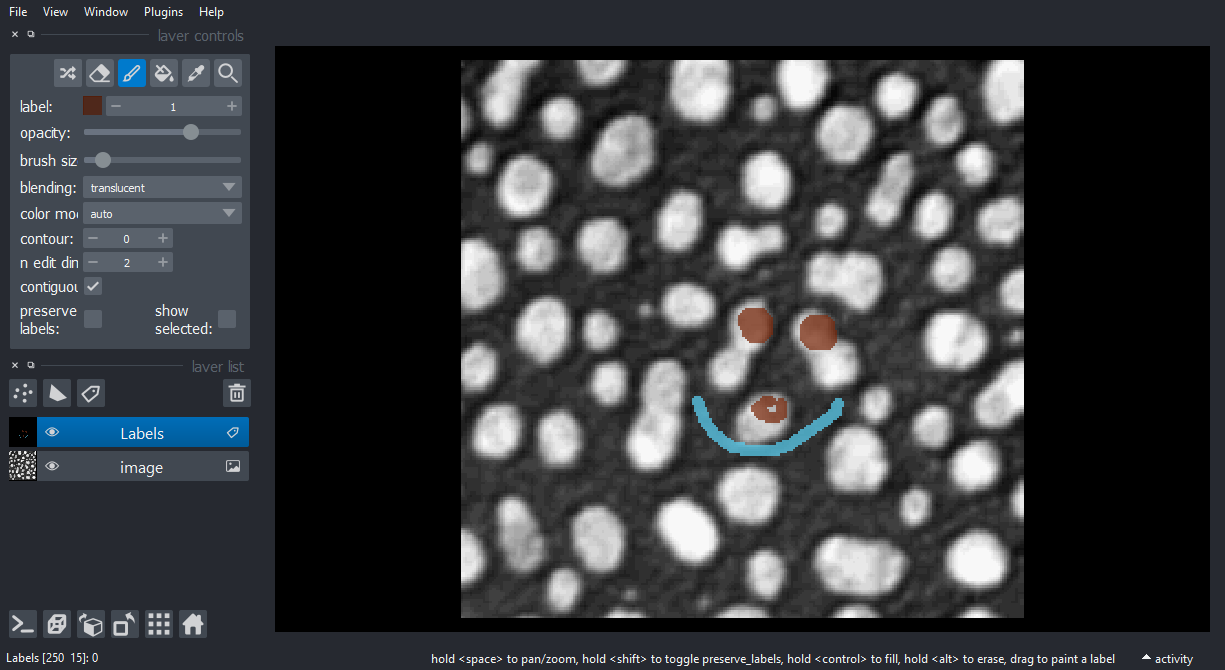

In [11]:
napari.utils.nbscreenshot(viewer)

Retrieve the annotations from the napari layer:

C:\Users\rober\miniconda3\envs\pyimagej\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


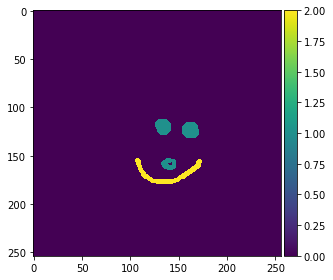

In [12]:
manual_annotations = labels.data

imshow(manual_annotations, vmin=0, vmax=2)

## Formating data
We now need to format the input data so that it fits to what scikit learn expects. Scikit-learn asks for an array of shape (n, m) as input data and (n) annotations. n corresponds to number of pixels and m to number of features. In our case m = 3.

In [14]:
def format_data(feature_stack, annotation):
    # reformat the data to match what scikit-learn expects
    # transpose the feature stack
    X = feature_stack.T
    # make the annotation 1-dimensional
    y = annotation.ravel()
    
    # remove all pixels from the feature and annotations which have not been annotated
    mask = y > 0
    X = X[mask]
    y = y[mask]

    return X, y

X, y = format_data(feature_stack, manual_annotations)

print("input shape", X.shape)
print("annotation shape", y.shape)

input shape (1049, 3)
annotation shape (1049,)


As we have used functions in the example above, we can just repeat the same procedure with the manual annotations.

In [15]:
# generate features (that's actually not necessary, 
# as the variable is still there and the image is the same. 
# but we do it for completeness)
feature_stack = generate_feature_stack(image)
X, y = format_data(feature_stack, manual_annotations)

# train classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

## Predicting pixel classes
After the classifier has been trained, we can use it to predict pixel classes for whole images. Note in the following code, we provide `feature_stack.T` which are more pixels then X in the commands above, because it also contains the pixels which were not annotated before.

C:\Users\rober\miniconda3\envs\pyimagej\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


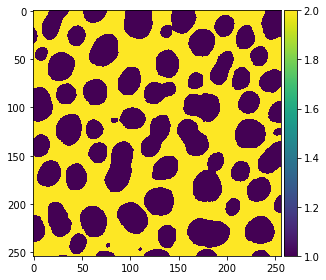

In [16]:
# process the whole image and show result
result_1d = classifier.predict(feature_stack.T)
result_2d = result_1d.reshape(image.shape)
imshow(result_2d)

Also we add the result to napari.

In [17]:
viewer.add_labels(result_2d)

<Labels layer 'result_2d' at 0x23260afae80>

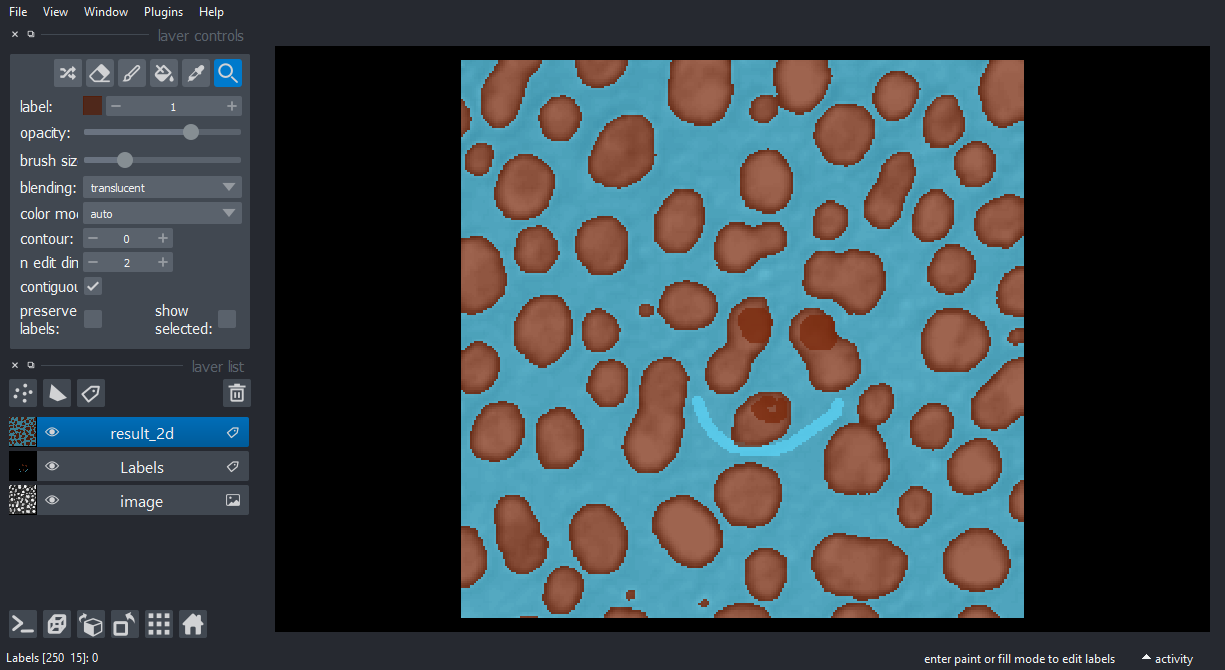

In [18]:
napari.utils.nbscreenshot(viewer)

# Exercise
Change the code so that you can annotate three different regions:
* Nuclei
* Background
* The edges between blobs and background